# 导入包

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# 定义函数

In [2]:
def showmat2d(mat):
    """ display 3-d mat
    """
    plt.figure()
    plt.imshow(mat)
    plt.show()
def showmat3d(mat):
    """ display 3-d mat
    """
    (h, w) = mat.shape
    x1 = np.arange(h); x2 = np.arange(w)
    x1, x2 = np.meshgrid(x1, x2)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x1, x2, mat, rstride=1, cstride=1, cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


def load_images():
    """ load 20 images
    Returns:
        images {ndarray(20, 1024)}
    """
    dirname = './data'
    images = np.zeros(shape=(20, 1024))
    for i in range(20):
        imgname = 'obj{:d}__0.png'.format(i+1)
        imgpath = os.path.join(dirname, imgname)
        image = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (32, 32))
        images[i] = image.reshape(-1)  
    return images
def calculateEuclidean(mat):
    """ 计算各样本间欧式距离
    Args:
        mat {ndarray(n_samples, n_features)}
    Returns:
        ret {ndarray(n_samples, n_samples)}
    """
    euclidean = lambda i, j: np.linalg.norm(mat[i] - mat[j])
    (n_samples, n_features) = mat.shape
    ret = np.zeros(shape=(n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i + 1):
            ret[i, j] = euclidean(i, j)
            ret[j, i] = ret[i, j]
    return ret
def calculateCosine(mat):
    """ 计算各样本间余弦距离
    Args:
        mat {ndarray(n_samples, n_features)}
    Returns:
        ret {ndarray(n_samples, n_samples)}
    """
    cosine = lambda i, j: mat[i].dot(mat[j]) \
                        / (np.linalg.norm(mat[i]) * np.linalg.norm(mat[j]))
    (n_samples, n_features) = mat.shape
    ret = np.zeros(shape=(n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i + 1):
            ret[i, j] = cosine(i, j)
            ret[j, i] = ret[i, j]
    return ret

# 定义类

In [3]:
class SVD():
    """ 奇异值分解
    Attributes:
        m {int}: 输入矩阵的行
        n {int}: 输入矩阵的列
        r {int}: 部分奇异值分解参数，若指定 r = -1, 那么 r = n
        isTrains {bool}: 若输入矩阵input.shape[0] < input.shape[1]，则isTrains = True
        U {ndarray(m, r)}
        S {ndarray(r, )}
        V {ndarray(n, r)}
    Notes:
        - 若 m < n, 则转置输入矩阵 m, n := n, m
        - 若特征值非零个数小于r，则重新赋值，即 r = \min \{ r, n_{\lambda \neq 0}
        - 为减小内存使用，奇异值保存在一维向量中
        - X' = U S V^T
    """
    def __init__(self, r=-1):
        self.m = None
        self.n = None
        self.r = r
        self.isTrans = False
        self.U = None
        self.S = None
        self.V = None
    def fit(self, X):
        """ 计算主成分
        Notes:
            - Transpose input matrix if m < n, and m, n := n, m
            - reassign self.r if eigvals contains zero
        """
        (self.m, self.n) = X.shape
        if self.m < self.n:
            X = X.T
            self.m, self.n = self.n, self.m
            self.isTrans = True
        self.r = self.n if (self.r == -1) else self.r

        XTX = X.T.dot(X)
        eigval, eigvec = np.linalg.eig(X.T.dot(X))
        eigval, eigvec = np.real(eigval), np.real(eigvec)
        
        self.S = np.sqrt(np.clip(eigval, 0, float('inf')))
        self.S = self.S[self.S > 0]
        self.r = min(self.r, self.S.shape[0])               # reassign self.r
        order = np.argsort(eigval)[::-1][: self.r]          # sort eigval from large to small
        eigval = eigval[order]; eigvec = eigvec[:, order]
        self.V = eigvec.copy()
        self.U = X.dot(self.V).dot(
                    np.linalg.inv(np.diag(self.S)))
        return self.U, self.S, self.V
    def compose(self, r=-1):
        """ 合并r个分量
        Args:
            r {int}: if r==-1, merge all components
        Returns:
            X {ndarray(m, n)}
        """
        if r == -1:
            X = self.U.dot(np.diag(self.S)).dot(self.V.T)
            X = X.T if self.isTrans else X
        else:
            (m, n) = (self.n, self.m) if self.isTrans else (self.m, self.n)
            X = np.zeros(shape=(m, n))
            for i in range(r):
                X += self.__getitem__(i)
        return X
    def __getitem__(self, idx):
        """ 返回指定索引的分量
        Args:
            index {int}: range from (0, self.r)
        """
        u = self.U[:, idx]
        v = self.V[:, idx]
        s = self.S[idx]
        x = s * u.reshape(self.m, 1).\
                    dot(v.reshape(1, self.n))
        x = x.T if self.isTrans else x
        return x
    def showComponets(self, r=-1):
        """ 显示主分量
        Notes:
            - Resize components' shape into (40, 30)
        """
        m, n = self.m, self.n
        r = self.r if r==-1 else r
        n_images = 10; m_images = r // n_images + 1
        m_size, n_size = 40, 30
        showfig = np.zeros(shape=(m_images*m_size, n_images*n_size))
        for i in range(r):
            m_pos = i // n_images
            n_pos = i %  n_images
            component = self.__getitem__(i)
            component = component.T if self.isTrans else component
            showfig[m_pos*m_size: (m_pos+1)*m_size, n_pos*n_size: (n_pos+1)*n_size] = cv2.resize(component, (30, 40))
        plt.figure('components')
        plt.imshow(showfig)
        plt.show()

# 导入一张图片并显示

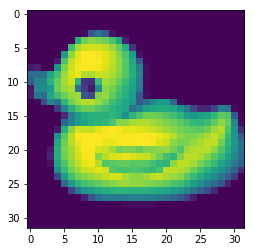

In [4]:
# 读取一张图片
X = load_images()[0].reshape((32, 32))
showmat2d(X)

# 奇异值分解，显示分类

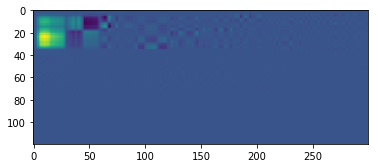

In [5]:
# 对图片进行奇异值分解
decomposer = SVD(r=-1)
decomposer.fit(X)
# 显示一下分量
decomposer.showComponets(r=-1)

# 组合分量

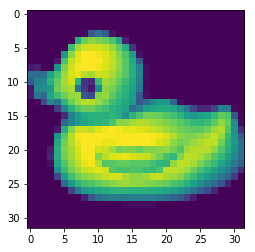

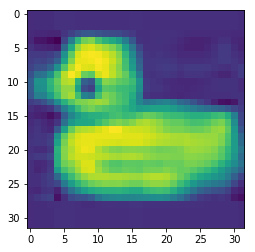

In [6]:

# 将全部分量组合，并显示
X_ = decomposer.compose(r=-1)
showmat2d(X_)
# 将前5个分量组合，并显示
X_ = decomposer.compose(r=5)
showmat2d(X_)